In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Indicator Function Approximation

Suppose that indicator function  $H(x) = 1[x>0]$ can be approximated by polynomial $\sum_{k=0}^d c_k x^k$ above. 

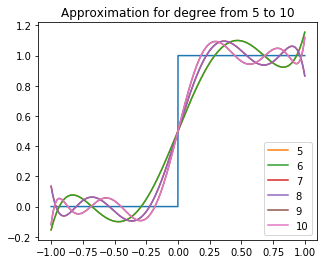

In [3]:
### chebyshev estimation for indicator loss function #########
# for deg from 5 to 10
# Chhebyshev http://mathworld.wolfram.com/ChebyshevApproximationFormula.html

x = np.arange(-1, 1, 0.001)
y = np.sign(x); y [ y == -1] = 0

c_all = dict()
fig = plt.figure(figsize=(5, 4))
plt.plot(x,y)

for deg in xrange(5, 11, 1):   
    c = np.polynomial.chebyshev.chebfit(x, y, deg)
    y3 = []
    for xx in x:
        y3.append(np.polynomial.chebyshev.chebval(xx, c))
    plt.plot(x,y3, label=str(deg))
    c_all[deg] = c

plt.title('Approximation for degree from 5 to 10')
plt.legend(loc=4)
plt.show()

for degree 7, its coefs are 0.5013 2.6917 -0.0148 -9.8694 0.0385 15.3964 -0.0275 -7.8554



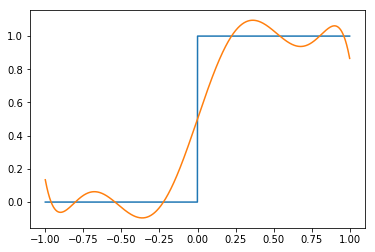

In [4]:
# we compute C_k in this cell for degree from 5 to 10

def ComputePoly(coef_poly, x):
    res = 0
    for idx, c in enumerate(coef_poly):
        res += c * np.power(x, idx)
    return res

coef_poly = dict()
for d in c_all:
    coef_poly[d] = np.polynomial.chebyshev.cheb2poly(c_all[d])

d = 7
y4 = []
for xx in x:
    y4.append(ComputePoly(coef_poly[d], xx))
plt.plot(x,y)
plt.plot(x,y4)
print 'for degree {}, its coefs are {}\n'.format(d, ' '.join([str(np.round(c, 4)) for c in coef_poly[d]]))
# print coef_poly[7], np.polynomial.chebyshev.chebfit(x, y, 7)
# print coef_poly[d][1], np.around(coef_poly[d][1], 4)

In [6]:
c_all[7]

array([ 0.5  ,  0.616, -0.001, -0.234, -0.   ,  0.103, -0.001, -0.123])

In [7]:
coef_poly[7]

array([  0.501,   2.692,  -0.015,  -9.869,   0.038,  15.396,  -0.027,
        -7.855])

## AUC Estimation

AUC of a predictor $f$ is defined as (where $f$ could be logistic, SVM, CNN or so on)

$$ AUC(f) = P( f(x) < f(y) \ \vert \ x \in D^0, y \in D^1)$$, 

where $D^0, D^1$ are the samples with true label 0 and 1 respectively. Therefore its naive estimation, i.e. $\textbf{Wilcoxon-Man-Whitney}$ statistics, is

$$ n_0 n_1 auc(f ) = \sum_{t_0\in D^0} \sum_{t_1 \in D^1} 1 [ f(t_0) < f(t_1) ] $$, 

where $n_0 = |D^0|, n_1 = |D^1|$.  The computation cost for WMW statistics is equivalent to sort $f(t)$

now consider approximate indicator function 1 by polynomial with degree $k$ above, i.e.
$$
\begin{align}
H( f(t_1) - f(t_0) ) & \approx \sum_{k=0}^d c_k (f(t_1) - f(t_0))^k  \\
                     & = \sum_{k=0}^d c_k \sum_{l=0}^k C_k^l f(t_1)^l (-f(t_0))^{k-l} \\
                     & = \sum_{k=0}^d \sum_{l=0}^k \alpha_{kl} f(t_1)^l f(t_0)^{k-l}.
\end{align}
$$
where $\alpha_{kl} = c_k C_k^l (-1)^{k-l}$ is the constant, next we compute $\alpha$s

In [8]:
### compute alphas #######
from scipy.special import comb

alphas = dict()

for d in coef_poly:
    a = np.zeros((d+1, d+1), dtype = np.float32)
    for k in xrange(d+1):
        for l in xrange(k+1):
            a[k,l] = coef_poly[d][k] * comb(k,l) * np.power(-1, k-l)
    alphas[d] = a
np.set_printoptions(precision=3, suppress=True)

### AUC Approximation by Polynomial

Then AUC can be approxiated by 
$$
\begin{align}
n_0 n_1 AUC(f) &= \sum_{t_0 \in D^0} \sum_{t_1 \in D^1} \sum_{k=0}^d \sum_{l=0}^k \alpha_{kl} f(t_1)^l f(t_0)^{k-1} \\
               &= \sum_{k=0}^d \sum_{l=0}^k \alpha_{kl} (\sum_{t_1 \in D^1} f(t_1)^l ) ( \sum_{t_0\in D^0} f(t_0)^{k-l})
\end{align}
$$

### AUC Optimization

if you are not going to use Theano and would like to compute the gradient by your self, here is a simple derivation 
$$ n_0 n_1 \frac{ \partial AUC(f)} {\partial w} = \sum_{k=0}^d \sum_{l=0}^k \alpha_{kl} 
(\frac{\partial \sum_{t_1\in D_1} f(t_1)^l}{\partial w} * \sum_{t_0 \in D_0} f(t_0)^{k-l}  + 
\sum_{t_1\in D_1} f(t_1)^l * \frac{\partial  \sum_{t_0 \in D_0} f(t_0)^{k-l}}{\partial w} )$$

In [5]:
# randomly generate some data for classification
import sklearn
from sklearn import datasets
from sklearn import linear_model
X, Y =  datasets.make_classification(100, 2, 2, 0, flip_y=0.4)

acc = 0.79


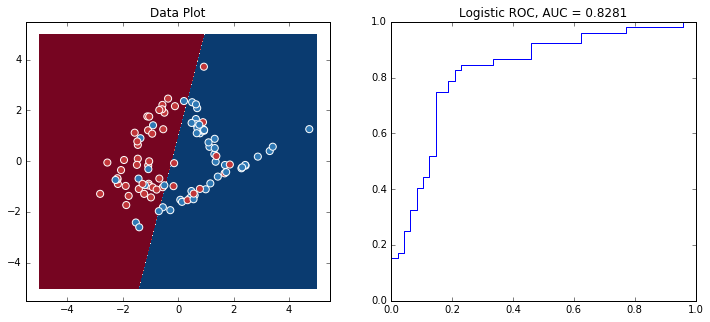

In [6]:
### visualization for 2D data point

X = X.astype(np.float32); Y = Y.astype(np.int32)

fig = plt.figure( figsize=(12, 5) )

ax = fig.add_subplot(121)
plt.title('Data Plot')

log_model =  linear_model.LogisticRegression()
log_model.fit(X, Y)
Y_pred = log_model.predict_proba(X)

xx, yy = np.mgrid[-5:5:.01, -5:5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = log_model.predict(grid).reshape(xx.shape)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)


# print xx.shape, xx.ravel().shape, grid.shape
# print np.c_[np.array([[1,2,3]]), 0, 0, np.array([[4,5,6]])]
# print np.c_[np.array([[1,2,3]]).reshape(3,1).ravel(), np.array([[4,5,6]]).reshape(3,1).ravel()]

plt.scatter(X[:,0], X[:, 1], c=Y, s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

fig.add_subplot(122)
fpr, tpr, _ = sklearn.metrics.roc_curve(Y, Y_pred[:,1])
auc = sklearn.metrics.roc_auc_score(Y, Y_pred[:,1])

plt.plot(fpr, tpr)
plt.title('Logistic ROC, AUC = ' + str( np.round(auc,4)) )
print 'acc =', np.mean( np.argmax(Y_pred,1)==Y)


In [7]:
########   now we approximate it ##################
D0 = np.where(Y == 0)[0]; D1 = np.where( Y == 1)[0]

In [8]:
#now we test the AUC estimation/approximation by WMW and polynomial
#which should be not too far from AUC above computed by sklearn

def AUC_WMW(Y_pred, D0, D1):
    auc_WMW = 0
    for i0 in D0:
        for i1 in D1:
            auc_WMW += Y_pred[i0] < Y_pred[i1]
    auc_WMW /= len(D0) * len(D1) * 1.0
    return auc_WMW

def AUC_Poly0(Y_pred, D0, D1, d=7):
    auc_poly0 = 0
    for i0 in D0:
        for i1 in D1:
            for k in xrange(d+1):
                auc_poly0 += coef_poly[d][k] * np.power((Y_pred[i1] - Y_pred[i0] ), k)
    auc_poly0 /= len(D0) * len(D1) * 1.0
    return auc_poly0

def AUC_Poly(Y_pred, D0, D1, d=7):
    auc_poly = 0
    for k in xrange(d+1):
        for l in xrange(k+1):
            auc_poly += alphas[d][k,l] * np.sum( np.power( Y_pred[D1], l) ) * np.sum( np.power( Y_pred[D0], k-l ) )
    auc_poly /= len(D0) * len(D1) * 1.0
    return auc_poly

print 'AUC estimated by Wilcoxon-Man-Whitney statistics is', AUC_WMW(Y_pred[:,1], D0, D1)
print 'AUC estimated by Chebyshev approx is (with c)', AUC_Poly0(Y_pred[:,1], D0, D1)
print 'AUC estimated by Chebyshev approx is (with alpha)', AUC_Poly(Y_pred[:,1], D0, D1, 5)

AUC estimated by Wilcoxon-Man-Whitney statistics is 0.828125
AUC estimated by Chebyshev approx is (with c) 0.833546158492
AUC estimated by Chebyshev approx is (with alpha) 0.841950894743


### Optimize Cross Entropy

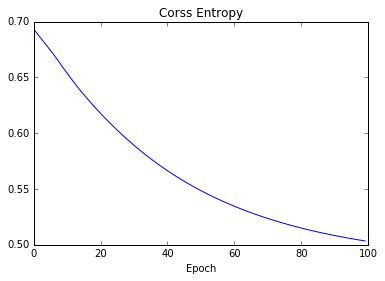

In [10]:
# in TensorFlow
# a simple logistic to optimize cross entropy loss

import tensorflow as tf
import tflearn

# def fully-connected layer
def dense(l_input, hidden_size, name='dense'):
    """
    Dense (Fully Connected) layer.
    Architecture: reshape - Affine - Softmax
    WARNING: should not be the output layer.  Use "output" for that.
    INPUTS:
    - l_input: (tensor.2d or more) basically, of size [batch_size, etc...]
    - hidden_size: (int) Number of hidden neurons.
    - name: (string) unique name for layer.
    """
    # Flatten Input Layer
    input_size = l_input.get_shape().as_list()
    reshape_size = 1
    for iter_size in range(1, len(input_size)):
        reshape_size *= input_size[iter_size]
    reshape_layer = tf.reshape(l_input, [-1, reshape_size])

    # Creating and Doing Affine Transformation
    weight_shape = [reshape_layer.get_shape().as_list()[1], hidden_size]
    std = 0.01  # np.sqrt(2.0 / reshape_layer.get_shape().as_list()[1])
    with tf.variable_scope(name + '_dense_weights', reuse=True):
        W = tf.get_variable(
            'W', weight_shape,
            initializer=tf.random_normal_initializer(stddev=std))
    tf.add_to_collection('reg_variables', W)
    affine_layer = tf.matmul(reshape_layer, W)

    # Softmax
    # final_layer = tf.nn.softmax(affine_layer)
    
    # ReLU
    final_layer = tf.maximum(affine_layer, 0)

    return final_layer


x = tf.placeholder(tf.float32, shape=(100,2), name='inputs')
y = tf.placeholder(tf.int64, shape=(100,), name='targets')


# train a simple model, one-layer of two hidden units
layer = x
pred = dense(layer, 2, name='AUC-approximate')
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(pred, y))
# print tf.nn.sparse_softmax_cross_entropy_with_logits(pred, y).get_shape()
optimizer = tf.train.AdamOptimizer(0.01).minimize(loss)
init = tf.global_variables_initializer()
    
# run training
sess = tf.Session()
sess.run(init)
        
loss_epoch = []
for i in xrange(100):
    _, loss_iter = sess.run((optimizer, loss), feed_dict={x: X, y: Y})
    loss_epoch.append(loss_iter)
        
# print sess.run(pred, feed_dict={x: X})
# print loss_iter
plt.plot(loss_epoch)
plt.title('Corss Entropy')
plt.xlabel('Epoch')

In [11]:
prob = tf.nn.softmax(pred)

# validation
prob = sess.run(prob, feed_dict={x: X})

print 'AUC is', AUC_WMW(prob[:,1], D0, D1), AUC_Poly(prob[:,1], D0, D1)

sess.close()

AUC is 0.836939102564 0.855333538583


### Directly Optimize AUC

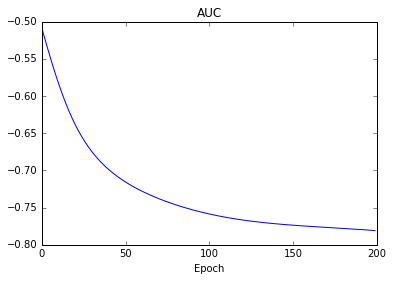

In [12]:
# in TensorFlow
# finally we directly optimize AUC

import tensorflow as tf
import tflearn

# def fully-connected layer
def dense(l_input, hidden_size, name='dense'):
    """
    Dense (Fully Connected) layer.
    Architecture: reshape - Affine - Softmax
    WARNING: should not be the output layer.  Use "output" for that.
    INPUTS:
    - l_input: (tensor.2d or more) basically, of size [batch_size, etc...]
    - hidden_size: (int) Number of hidden neurons.
    - name: (string) unique name for layer.
    """
    # Flatten Input Layer
    input_size = l_input.get_shape().as_list()
    reshape_size = 1
    for iter_size in range(1, len(input_size)):
        reshape_size *= input_size[iter_size]
    reshape_layer = tf.reshape(l_input, [-1, reshape_size])

    # Creating and Doing Affine Transformation
    weight_shape = [reshape_layer.get_shape().as_list()[1], hidden_size]
    std = 0.01  # np.sqrt(2.0 / reshape_layer.get_shape().as_list()[1])
    with tf.variable_scope(name + '_dense_weights', reuse=True):
        W = tf.get_variable(
            'W', weight_shape,
            initializer=tf.random_normal_initializer(stddev=std))
    tf.add_to_collection('reg_variables', W)
    affine_layer = tf.matmul(reshape_layer, W)

    # Softmax
    # final_layer = tf.nn.softmax(affine_layer)
    
    # ReLU
    final_layer = tf.maximum(affine_layer, 0)

    return final_layer


x = tf.placeholder(tf.float32, shape=(100,2), name='inputs')
y = tf.placeholder(tf.int64, shape=(100,), name='targets')

layer = x
pred = dense(layer, 2, name='AUC-approximate')


# the only difference we use here is we use negative AUC as loss
# we analyze the computation cost of AUC. suppose there are n samples
# (d+2) * (d+1) /2 for the for loop
# the sum takes 6n u
# so overall it takes   (d+2)*(d+1)/2 * 8n * N_LABELS operation
# compare to regular cross entropy loss, whose computation cost is N_LABELs * n

label_we_care = 1
# init_loss = tf.placeholder(tf.float32, shape=None, name='init_loss')
init_loss = tf.Variable(tf.constant(0.0), name='init_loss')
auc_loss = init_loss + 0.0

init = tf.global_variables_initializer()
saver = tf.train.Saver()

sess = tf.Session()
sess.run(init)

# calculate AUC loss
for k in xrange(d+1):
    for l in xrange(k+1):
        auc_loss = auc_loss\
                   - alphas[d][k,l]\
                   * tf.reduce_sum(tf.pow(pred[:,label_we_care], l)\
                                   * tf.cast(tf.equal(y, label_we_care), tf.float32))\
                   * tf.reduce_sum(tf.pow(pred[:,label_we_care], k-l)\
                                   * tf.cast(tf.not_equal(y, label_we_care), tf.float32))
        
auc_loss /= len(D0) * len(D1) 


optimizer = tf.train.GradientDescentOptimizer(0.001).minimize(auc_loss)

# run training    
auc_loss_epoch = []
for i in xrange(200):
    _, auc_loss_iter = sess.run((optimizer, auc_loss), feed_dict={x: X, y: Y})
    # auc_loss_iter = sess.run(auc_loss, feed_dict={x: X, y: Y, init_loss:0.0})
    auc_loss_epoch.append(auc_loss_iter)
    # print auc_loss_iter


plt.plot(auc_loss_epoch)
plt.title('AUC')
plt.xlabel('Epoch')

sess.close()


### Harder Experiment

acc = 0.769


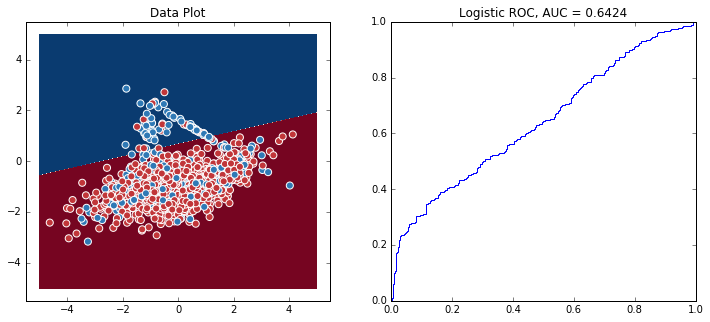

In [15]:
####### try some harder data
### visualization for 2D data point

X, Y =  datasets.make_classification(1000, 2, 2, 0, weights=[0.9, 0.1], flip_y=0.4)

########   now we approximate it ##################
D0 = np.where(Y == 0)[0]; D1 = np.where( Y == 1)[0]

fig = plt.figure( figsize=(12, 5) )
ax = fig.add_subplot(121)
plt.title('Data Plot')

log_model =  linear_model.LogisticRegression()
log_model.fit(X, Y)
Y_pred = log_model.predict_proba(X)

xx, yy = np.mgrid[-5:5:.01, -5:5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = log_model.predict(grid).reshape(xx.shape)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)

plt.scatter(X[:,0], X[:, 1], c=Y, s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

fig.add_subplot(122)
fpr, tpr, _ = sklearn.metrics.roc_curve(Y, Y_pred[:,1])
auc = sklearn.metrics.roc_auc_score(Y, Y_pred[:,1])

plt.plot(fpr, tpr)
plt.title('Logistic ROC, AUC = ' + str( np.round(auc,4)) )
print 'acc =', np.mean( np.argmax(Y_pred,1)==Y)

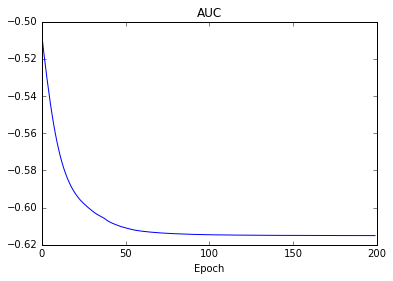

In [17]:
# in TensorFlow
# finally we directly optimize AUC

import tensorflow as tf
import tflearn

# def fully-connected layer
def dense(l_input, hidden_size, name='dense'):
    """
    Dense (Fully Connected) layer.
    Architecture: reshape - Affine - Softmax
    WARNING: should not be the output layer.  Use "output" for that.
    INPUTS:
    - l_input: (tensor.2d or more) basically, of size [batch_size, etc...]
    - hidden_size: (int) Number of hidden neurons.
    - name: (string) unique name for layer.
    """
    # Flatten Input Layer
    input_size = l_input.get_shape().as_list()
    reshape_size = 1
    for iter_size in range(1, len(input_size)):
        reshape_size *= input_size[iter_size]
    reshape_layer = tf.reshape(l_input, [-1, reshape_size])

    # Creating and Doing Affine Transformation
    weight_shape = [reshape_layer.get_shape().as_list()[1], hidden_size]
    std = 0.01  # np.sqrt(2.0 / reshape_layer.get_shape().as_list()[1])
    with tf.variable_scope(name + '_dense_weights', reuse=True):
        W = tf.get_variable(
            'W', weight_shape,
            initializer=tf.random_normal_initializer(stddev=std))
    tf.add_to_collection('reg_variables', W)
    affine_layer = tf.matmul(reshape_layer, W)

    # Softmax
    # final_layer = tf.nn.softmax(affine_layer)
    
    # ReLU
    final_layer = tf.maximum(affine_layer, 0)

    return final_layer


x = tf.placeholder(tf.float32, shape=(1000,2), name='inputs')
y = tf.placeholder(tf.int64, shape=(1000,), name='targets')

layer = x
pred = dense(layer, 2, name='AUC-approximate')


# the only difference we use here is we use negative AUC as loss
# we analyze the computation cost of AUC. suppose there are n samples
# (d+2) * (d+1) /2 for the for loop
# the sum takes 6n u
# so overall it takes   (d+2)*(d+1)/2 * 8n * N_LABELS operation
# compare to regular cross entropy loss, whose computation cost is N_LABELs * n

label_we_care = 1
init_loss = tf.Variable(tf.constant(0.0, dtype=tf.float32), name='init_loss')
auc_loss = init_loss + 0.0

init = tf.global_variables_initializer()
saver = tf.train.Saver()

sess = tf.Session()
sess.run(init)

# calculate AUC loss
for k in xrange(d+1):
    for l in xrange(k+1):
        auc_loss = auc_loss\
                   - alphas[d][k,l]\
                   * tf.reduce_sum(tf.pow(pred[:,label_we_care], l)\
                                   * tf.cast(tf.equal(y, label_we_care), tf.float32))\
                   * tf.reduce_sum(tf.pow(pred[:,label_we_care], k-l)\
                                   * tf.cast(tf.not_equal(y, label_we_care), tf.float32))
        
auc_loss /= len(D0) * len(D1) 


optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(auc_loss)

# run training    
auc_loss_epoch = []
for i in xrange(200):
    _, auc_loss_iter = sess.run((optimizer, auc_loss), feed_dict={x: X, y: Y})
    # auc_loss_iter = sess.run(auc_loss, feed_dict={x: X, y: Y, init_loss:0.0})
    auc_loss_epoch.append(auc_loss_iter)
    # print auc_loss_iter


plt.plot(auc_loss_epoch)
plt.title('AUC')
plt.xlabel('Epoch')

sess.close()